In [1]:
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
import osmnx as nx
import shapely
import multiprocess as mp
import numpy as np
import math

crs_fr = 2154


In [2]:
# --- From Anastassia
# import packages
%run -i packages.py

# CUSTOM FUNCTION

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)

In [3]:
#--- Get relevant shapes and data

# GPM outline
GPM = gpd.read_file('data/raw/GPM.geojson').to_crs(crs_fr)

# IRIS codes and shapes 
IRIS_GPM = gpd.read_file('data/raw/IRIS_GPM.geojson')

# Where are schools located in the Grand Paris Metropolis?

In [4]:
#--- Get education-related amenities from OSM

# Define tags
tags = {'amenity': 'school'}
place_name = 'Grand Paris Metropolis, France'

# Get the data
buildings = ox.geometries_from_place(place_name, tags).reset_index(drop=False)

# Keep relevant columns
col_tokeep = ['osmid', 'geometry', 'amenity', 'name', 'school:FR']
buildings = buildings[col_tokeep].to_crs(IRIS_GPM.crs)
buildings.shape

(4337, 5)

In [5]:
#--- Group by type and by IRIS

# Only keep buildings with some sort of name (so they can be checked)
buildings['name'] = buildings['name'].fillna(buildings['school:FR'])
buildings_notnull = buildings.loc[buildings['name'].notnull()].drop_duplicates(subset=['geometry'], keep='first').drop(columns = ['school:FR', 'osmid'])
len(buildings_notnull)

# Prep the tables
buildings_notnull['geometry'] = buildings_notnull['geometry'].centroid
buildings_notnull = buildings_notnull.drop(columns = 'name')

# Perform the spatial join
joined_table = gpd.sjoin(buildings_notnull, IRIS_GPM, how = 'right', predicate='within')

# Find buildings that are close to the border
unmatched_buildings = buildings_notnull[~buildings_notnull.index.isin(joined_table['index_left'])]
buffer_distance = 50 
unmatched_buildings['geometry'] = unmatched_buildings.buffer(buffer_distance)
buffer_gdf = gpd.GeoDataFrame(unmatched_buildings ,geometry='geometry', crs=buildings_notnull.crs)

# Add missing buildings to the table
buffer_joined_table = gpd.sjoin(buffer_gdf, IRIS_GPM, how = 'right')
buffer_joined_table.isnull().sum()
joined_table = pd.concat([joined_table, buffer_joined_table], ignore_index=True).drop(columns = ['index_left'])

# Count the number of each building amenity in each IRIS
pivot_table = joined_table.pivot_table(index='CODE_IRIS', columns='amenity', aggfunc='count', fill_value=0)
pivot_table.columns = pivot_table.columns.map(lambda x: f'{x[1]}_count')
pivot_table = pivot_table.reset_index()

# Add geometry
final_table = pivot_table.merge(IRIS_GPM[['CODE_IRIS', 'geometry']], on='CODE_IRIS', how = 'right').fillna(0)

# turn everything except the geometry to int64 type
final_table.iloc[:, 0:-1] = final_table.iloc[:, 0:-1].astype('int64')
final_table = final_table.loc[:,~final_table.columns.duplicated()].copy()

education_perIRIS = final_table
education_perIRIS.head(2)

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_35867/3253410749.py:35: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final_table.iloc[:, 0:-1] = final_table.iloc[:, 0:-1].astype('int64')


,CODE_IRIS,school_count,geometry
0,920440109,3,"POLYGON ((648055.600 6866209.000, 648025.400 6..."
1,930270105,1,"POLYGON ((656803.300 6869116.600, 656753.200 6..."


In [6]:
education_perIRIS.dtypes

CODE_IRIS          int64
school_count       int64
geometry        geometry
dtype: object

In [7]:
education_perIRIS.shape

(2666, 3)

# How many school-aged children are there in each IRIS?

In [8]:
# From https://www.insee.fr/fr/statistiques/6456153?sommaire=6456166#dictionnaire
#--- Get data on the age ranges of the population 

df = pd.read_csv('data/raw/struct-pop-2019/struct-pop-2019.CSV', sep = ';')
df_meta = pd.read_csv('data/raw/struct-pop-2019/meta-struct-pop-2019.CSV', sep = ';')
df['IRIS'] = df['IRIS'].astype('string')

vars_of_interest = ['IRIS',
                    'P19_POP', # Total population
                    'P19_POP0305', # Population 3-5 years old -> goes to school
                    'P19_POP0610', # Population 6-10 years old -> goes to school
                    'P19_POP1117', # Population 11-17 years old -> goes to school    
                    'COM'                
                    ]

df_meta_vars = df_meta.loc[df_meta['COD_VAR'].isin(vars_of_interest)].drop_duplicates(subset = 'COD_VAR')
df_narrow_IRIS = df.loc[(df['IRIS'].isin(IRIS_GPM['CODE_IRIS'])), df_meta_vars['COD_VAR'].values]

# Combine all age groups that go to school into one column
df_narrow_IRIS['P19_POP_SCHOOL'] = df_narrow_IRIS['P19_POP0305'] + df_narrow_IRIS['P19_POP0610'] + df_narrow_IRIS['P19_POP1117']

# Remove the columns that were combined
age_range_IRIS = df_narrow_IRIS.drop(columns = ['P19_POP0305', 'P19_POP0610', 
                                                'P19_POP1117'])


# Add missing data (use median of the commune)
P19_pop_commune_median = age_range_IRIS.loc[age_range_IRIS['COM'] == 94022]['P19_POP'].median()
P19_pop_school_commune_median = age_range_IRIS.loc[age_range_IRIS['COM'] == 94022]['P19_POP_SCHOOL'].median()

# Add data to the 3 missing IRIS (use the median of the commune)
row1 = ['940220101', P19_pop_commune_median, P19_pop_school_commune_median]
row2 = ['940220103', P19_pop_commune_median, P19_pop_school_commune_median]
row3= ['940220104', P19_pop_commune_median, P19_pop_school_commune_median]
df2 = pd.DataFrame([row1, row2, row3],
                   columns=['IRIS', 'P19_POP', 'P19_POP_SCHOOL'])

age_range_IRIS = pd.concat([age_range_IRIS, df2]).drop(columns = 'COM').reset_index(drop=True)
age_range_IRIS['IRIS'] = age_range_IRIS['IRIS'].astype('int')
age_range_IRIS.shape

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_35867/296220749.py:5: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/raw/struct-pop-2019/struct-pop-2019.CSV', sep = ';')


(2666, 3)

# Calculating a vulnerability index
Based on the presence/absence of a school and the distance to the nearest school (if there is none present in the IRIS)

## Combining the datasets

<Axes: >

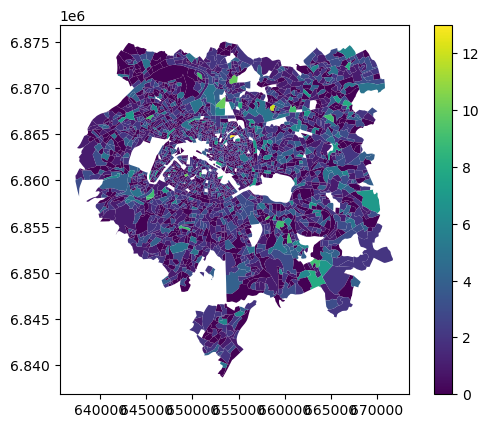

In [9]:
#--- Combine age ranges and school locations
age_school_IRIS = age_range_IRIS.merge(education_perIRIS, left_on = 'IRIS', right_on = 'CODE_IRIS', how = 'outer')
age_school_IRIS = gpd.GeoDataFrame(age_school_IRIS, geometry = 'geometry')
age_school_IRIS.plot(column = 'school_count', legend = True)

## Simplest Metric
Vulnerability = 0 if there is a school in the IRIS

Vulnerability = 1 if there isn't 

<Axes: >

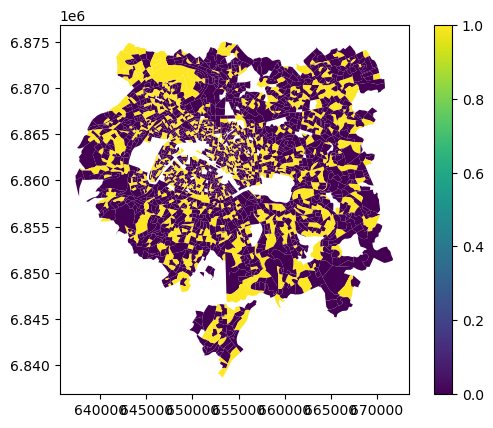

In [10]:
# Add a simple vulmerability metric to the dataframe
age_school_IRIS['vulnerability_simple'] = age_school_IRIS['CODE_IRIS'].isin(age_school_IRIS.loc[(age_school_IRIS['school_count']==0) &
                                                              (age_school_IRIS['P19_POP_SCHOOL'] > 0)]['CODE_IRIS'].tolist())
age_school_IRIS['vulnerability_simple'] = age_school_IRIS['vulnerability_simple'].astype(int)
age_school_IRIS.plot(column = 'vulnerability_simple', legend = True)

## More complex metric 1
Vulnarability is scaled between 0 and 1 based on the travel time to the nearest school. 

IRIS with a school are still at vulnerability 0, but those without a school can be compared to each other based on the travel time to the nearest school. 


CHECKS:
ONLY CENTROID NODES SHOULD HAVE SCHOOLS AND POPULATIONS

### Step 1: Create the complete network to calculate travel times

In [11]:
#--- Get data, turn to GeoDataFrame
# Edges
edges_with_id = pd.read_csv('data/clean/initial_network_edges_complete.csv')
edges_with_id["geometry"] = edges_with_id.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_with_id = gpd.GeoDataFrame(edges_with_id, geometry = 'geometry', crs = 4326).to_crs(2154)

# Nodes
nodes_carbike_centroids_RER_complete = pd.read_csv('data/clean/initial_network_nodes_complete.csv').drop(columns = 'attr_dict')
nodes_carbike_centroids_RER_complete["geometry"] = nodes_carbike_centroids_RER_complete.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_carbike_centroids_RER_complete = gpd.GeoDataFrame(nodes_carbike_centroids_RER_complete, geometry = 'geometry', crs = 4326).to_crs(2154)

# GPM
GPM = GPM.to_crs(4326)

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_35867/3071740452.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes_carbike_centroids_RER_complete = pd.read_csv('data/clean/initial_network_nodes_complete.csv').drop(columns = 'attr_dict')


In [12]:
#--- Add the number of schools of each centroid to the dataframe
# Match the centroids to their corresponding IRIS
nodes_carbike_centroids_RER_withschools = pd.merge(nodes_carbike_centroids_RER_complete, age_school_IRIS, left_on = 'CODE_IRIS', right_on = 'CODE_IRIS', how = 'left').drop(columns = 'geometry_y').rename(columns = {'geometry_x': 'geometry'})

# Check this is empty
print(nodes_carbike_centroids_RER_withschools[(nodes_carbike_centroids_RER_withschools['centroid'] == True) & (nodes_carbike_centroids_RER_withschools['IRIS'].isnull())])

Empty GeoDataFrame
Columns: [osmid, y, x, geometry, nodetype, centroid, RER, ligne, CODE_IRIS, P19_POP, IRIS, P19_POP_SCHOOL, school_count, vulnerability_simple]
Index: []


In [13]:
# Recreate the attr_dict because python ...
nodes_carbike_centroids_RER_withschools["attr_dict"] = nodes_carbike_centroids_RER_withschools.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  pos = (x.x, x.y),
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER,
                                                                  IRIS = x.IRIS,
                                                                  children_pop = x.P19_POP_SCHOOL,
                                                                  num_schools = x.school_count),
                                                                  axis = 1) 

In [14]:
#--- Create Graph with all nodes and edges
G = nx.from_pandas_edgelist(edges_with_id, source='x', target='y', edge_attr=True)
G.add_nodes_from(nodes_carbike_centroids_RER_withschools.loc[:,["osmid", "attr_dict"]].itertuples(index = False))

#--- Check if all nodes and edges are present
# Both should be 0
print(len(G.nodes()) - len(nodes_carbike_centroids_RER_withschools))
print(len(G.edges()) - len(edges_with_id))

0
-20


In [15]:
#--- Create "bikeable" network B (Anastassia)
B = G.copy()
bikeable_nodes = [node for node in B.nodes if B.nodes[node]["nodetype"]!="car"] # TODO addor/ if nodetype != RER
B_noncar_induced = B.subgraph(bikeable_nodes).copy() 

# induced subgraph - still contains the car edges that lie between multi nodes; - exclude them:
banw = B_noncar_induced.copy()
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="car"])
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="RER"])

#--- Check if all nodes and edges are present
# Both should be 0
print(len(banw.nodes()) 
      - len(nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['nodetype'] == 'bike']))
print(len(banw.edges()) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'bike']) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'both'])) # -3?


0
-3


In [16]:
#--- Create "RER" network R (based on Anastassia)
R = G.copy()
RER_nodes = [node for node in R.nodes if (R.nodes[node]["RER"] == True)] 
R_noncar_induced = R.subgraph(RER_nodes).copy() 

# induced subgraph - still contains the car edges that lie between multi nodes; - exclude them:
RERG = R_noncar_induced.copy()
RERG.remove_edges_from([edge for edge in RERG.edges if RERG.edges[edge]["edgetype"]=="car"])
RERG.remove_edges_from([edge for edge in RERG.edges if RERG.edges[edge]["edgetype"]=="bike"])

#--- Check if all nodes and edges are present
# Both should be 0
print(len(RERG.nodes()) 
      - len(nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['RER'] == True]))
print(len(RERG.edges()) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'RER']) ) 


0
0


In [17]:
#--- Make all networks undirected
# G = G.to_undirected()
print(nx.is_connected(G)) # True
banw = banw.to_undirected()
print(nx.is_connected(banw)) # most likely False
RERG = RERG.to_undirected()
print(nx.is_connected(RERG)) # True

True
False
True


In [18]:
#--- A BUNCH OF CHECKS



#--- Routing between centroids
# Pick two random nodes with centroid = True
start_node = nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['centroid'] == True].sample(1)
end_node = nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['centroid'] == True].sample(1)

# Check if they are connected on the bike network
print(nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) # Can be False

# Check if they are connected on the car network
# Always True!!!!!!!
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))




#--- Routing between RER stations

# Pick two random nodes with RER = True
start_node = nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['RER'] == True].sample(1)
end_node = nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['RER'] == True].sample(1)

# Check if they are connected on the bike network
print(nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) #Can be false

# Check if they are connected on the car network
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) #always True

# Check if they are connected on the RER network
print(nx.has_path(RERG, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) #always True


False
True
False
True
True


<Axes: >

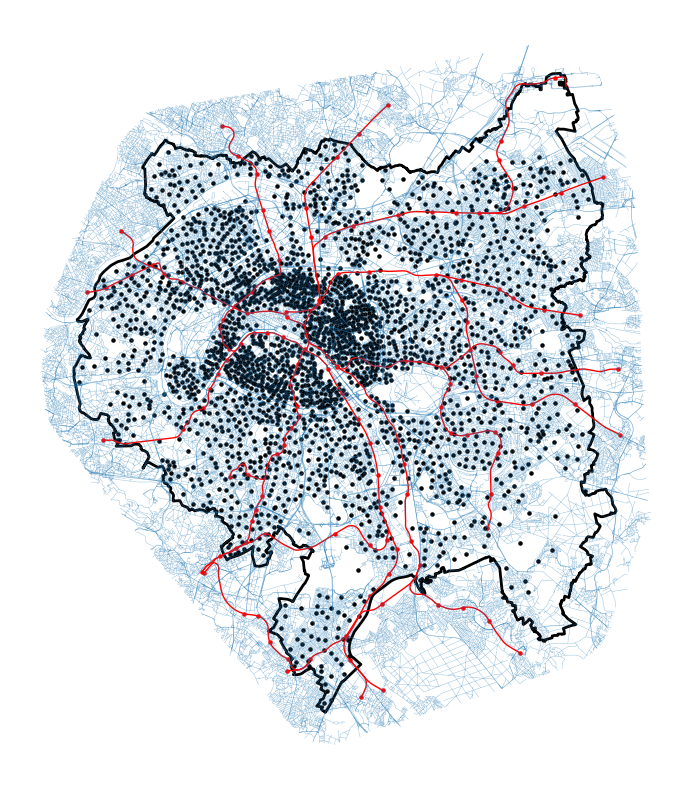

In [19]:
#--- Plot of everything for glory
plt.rcParams['figure.figsize'] = (10, 10)

ax = plt.axes()
plt.axis('off')
edges_with_id.loc[edges_with_id['edgetype'] == 'RER'].plot(ax=ax, linewidth = 1, alpha = 1, edgecolor = 'red')
edges_with_id.loc[edges_with_id['edgetype'] != 'RER'].plot(ax=ax, linewidth = 0.3, alpha = 0.5)


# nodes_carbike_centroids_RER_complete.loc[(nodes_carbike_centroids_RER_complete['RER'] == False) & (nodes_carbike_centroids_RER_complete['centroid'] == False)].plot(ax=ax, markersize = 0.05, facecolor = 'green', alpha = 0.5)
nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['RER'] == True].plot(ax=ax, markersize = 5, facecolor = 'red', alpha = 1)
nodes_carbike_centroids_RER_withschools.loc[nodes_carbike_centroids_RER_withschools['centroid'] == True].plot(ax=ax, markersize = 5, facecolor = 'black', alpha = 1)

GPM.to_crs(2154).plot(ax=ax, facecolor = 'none', linewidth = 2)


### Step 2: Find the shortes trip from any IRIS without school to the nearest school

In [20]:
# Make a list of all centroid nodes that don't have schools 
centroids_without_schools = list(nodes_carbike_centroids_RER_withschools.loc[(nodes_carbike_centroids_RER_withschools['centroid'] == True) & (nodes_carbike_centroids_RER_withschools['school_count'] == 0)]['osmid'])
print(len(centroids_without_schools))

# Make a list of all centroid nodes that DO have schools
centroids_with_schools = list(nodes_carbike_centroids_RER_withschools.loc[(nodes_carbike_centroids_RER_withschools['centroid'] == True) & (nodes_carbike_centroids_RER_withschools['school_count'] > 0)]['osmid'])
print(len(centroids_with_schools))



921
1745


In [21]:
#--- Multiprocessing AND filter for subset of target nodes

graph = G
set1 = centroids_without_schools
set2 = centroids_with_schools
original_set2 = set2  
ranges_dict = {}
filtered_set2_dict = {}

# Calculate and store the ranges for each node in set1
for node_set1 in set1:
    # Create lat and lon ranges for each node of set1
    if node_set1 not in G:
        ranges_dict[node_set1] = None
        continue

    lat = G.nodes[node_set1]['lat']
    lon = G.nodes[node_set1]['lon']
    buffer = 0.15  # Play around with this

    lat_min = lat - buffer
    lat_max = lat + buffer
    lon_min = lon - buffer
    lon_max = lon + buffer

    ranges_dict[node_set1] = {'lat_min': lat_min, 'lat_max': lat_max, 'lon_min': lon_min, 'lon_max': lon_max}

    # Filter set2 based on latitude and longitude ranges
    filtered_set2 = []
    for node_set2 in original_set2:
        if node_set2 not in G:
            continue
        latitude = G.nodes[node_set2]['lat']  # Access the latitude attribute of the node
        longitude = G.nodes[node_set2]['lon']  # Access the longitude attribute of the node
        if lat_min <= latitude <= lat_max and lon_min <= longitude <= lon_max:
            filtered_set2.append(node_set2)

    filtered_set2_dict[node_set1] = filtered_set2

# Function to calculate the shortest path for all nodes of set1
def process_node(node_set1):
    if node_set1 not in G:
        return node_set1, None, None

    ranges = ranges_dict[node_set1]
    if ranges is None:
        return node_set1, None, None

    filtered_set2 = filtered_set2_dict[node_set1]

    if not filtered_set2:
        return node_set1, None, None
        
    if node_set1 not in G or not all(node in G for node in filtered_set2):
        return node_set1, None, None
    
    
    shortest_paths = nx.single_source_dijkstra_path_length(graph, node_set1)
    shortest_paths = {node2: distance for node2, distance in shortest_paths.items() if node2 in filtered_set2}
    closest_node, shortest_distance = min(shortest_paths.items(), key=lambda x: x[1])

    return node_set1, closest_node, shortest_distance

if __name__ == '__main__':
    # Number of processes (cores) to use for parallel processing
    num_processes = 4

    # Create a pool of processes
    pool = mp.Pool(processes=num_processes)

    # Apply the function to each node in set1 using parallel processing
    results = pool.map(process_node, set1)

    # Close the pool
    pool.close()
    pool.join()
 
# Create a dictionary from the results
results_dict = {node_set1: {'closest_node_set2': closest_node_set2, 'path_length': path_length, 'IRIS': int(G.nodes[node_set1]['IRIS'])} for node_set1, closest_node_set2, path_length in results}


/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x112bd8f40>
  self.pid = os.fork()
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x112bd8f40>
  self.pid = os.fork()
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x112bd8f40>
  self.pid = os.fork()
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x112bd8f40>
  self.pid = os.fork()


### Step 3: Scale the results to create a vulnerability metric


In [37]:
# Prep data
results_df = pd.DataFrame.from_dict(results_dict, orient='index', dtype=None, columns=None).reset_index().rename(columns={'index':'node_set1'})
results_df = results_df.drop_duplicates(subset=['IRIS'], keep='first')

# Join the age_school_IRIS and the results_df
age_school_IRIS = age_school_IRIS.merge(results_df, left_on='CODE_IRIS', right_on='IRIS', how='left')

# Fill na accordingly
age_school_IRIS['path_length'] = age_school_IRIS['path_length'].fillna(0)

# Define vulnerability as the scaled path length
# = 0 for path length 0, =1 for max path length
age_school_IRIS['vulnerability_pathlength'] = age_school_IRIS['path_length'] / age_school_IRIS['path_length'].max()
age_school_IRIS.head(1)

KeyError: 'path_length'

In [ ]:
# Check there are exactly 2666 IRIS
age_school_IRIS.IRIS_x.nunique()

2666

In [ ]:
age_school_IRIS

,P19_POP,IRIS_x,P19_POP_SCHOOL,CODE_IRIS,school_count,geometry,vulnerability_simple,node_set1,closest_node_set2,path_length,IRIS_y,vulnerability_pathlength
0,949.437277,751010101,120.926298,751010101,1,"POLYGON ((652130.300 6862122.400, 652126.100 6...",0,NaN,NaN,0.000000,NaN,0.000000
1,2090.235257,751010201,150.158591,751010201,0,"POLYGON ((652203.200 6862692.000, 652214.400 6...",1,1285.0,2164.0,4.007008,751010201.0,0.130413
2,1657.745711,751010202,182.822372,751010202,1,"POLYGON ((651529.900 6862629.400, 651540.100 6...",0,NaN,NaN,0.000000,NaN,0.000000
3,2369.336175,751010203,266.460598,751010203,0,"POLYGON ((651714.000 6862876.100, 651773.000 6...",1,2452.0,1915.0,4.074570,751010203.0,0.132612
4,2155.612624,751010204,264.227427,751010204,0,"POLYGON ((652196.800 6862680.900, 651848.800 6...",1,2642.0,218.0,3.110134,751010204.0,0.101223
...,...,...,...,...,...,...,...,...,...,...,...,...
2661,3134.273605,950181002,716.930804,950181002,1,"POLYGON ((647763.400 6873263.800, 647671.200 6...",0,NaN,NaN,0.000000,NaN,0.000000
2662,2257.580060,950181003,477.573253,950181003,0,"POLYGON ((647139.800 6873018.700, 647161.700 6...",1,2307.0,2756.0,11.800643,950181003.0,0.384067
2663,2570.192234,940220101,503.315354,940220101,5,"POLYGON ((656500.900 6852179.200, 656480.600 6...",0,NaN,NaN,0.000000,NaN,0.000000
2664,2570.192234,940220103,503.315354,940220103,1,"POLYGON ((656445.700 6851426.800, 656452.700 6...",0,NaN,NaN,0.000000,NaN,0.000000


## Comparing the metrics (graphically and Gini-wise)

<Axes: title={'center': 'Vulnerability (path length)'}>

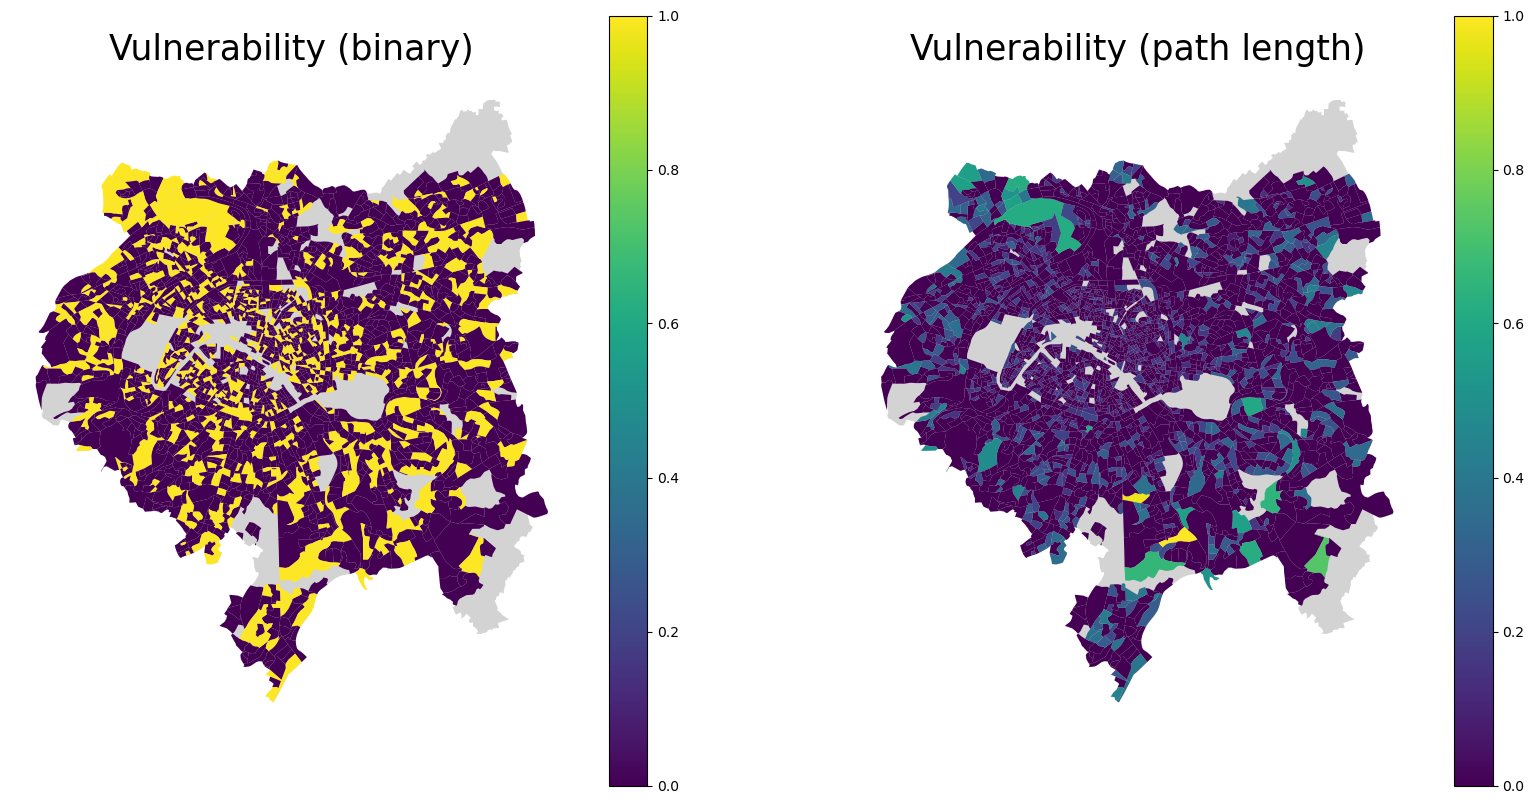

In [38]:
#--- Plot both metrics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Remove axes in both subplots
ax1.axis('off')
ax2.axis('off')

# Plot GPM background
GPM = GPM.to_crs(age_school_IRIS.crs)
GPM.plot(ax=ax1, color='lightgrey', edgecolor='white')
GPM.plot(ax=ax2, color='lightgrey', edgecolor='white')

# Give a title to each subfigure
ax1.set_title('Vulnerability (binary)', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax2.set_title('Vulnerability (path length)', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Plot the data
nodes_carbike_centroids_RER_withschools = nodes_carbike_centroids_RER_withschools.set_geometry('geometry')
age_school_IRIS.plot(column = 'vulnerability_simple', ax = ax1, legend = True)
age_school_IRIS.plot(column='vulnerability_pathlength', ax=ax2, legend=True)


In [39]:
# Define a function to calculate the Gini index of a column
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))


In [40]:
print("Gini index of the simple vulnerability index: ", gini(nodes_carbike_centroids_RER_withschools['vulnerability_simple']))
print("Gini index of the path length vulnerability index: ", gini(age_school_IRIS['vulnerability_pathlength']))

Gini index of the simple vulnerability index:  0.00033212153360715846
Gini index of the path length vulnerability index:  0.7489888121562288


In [41]:
#--- Add population density for the OD matrix later
# Calculate the area of each polygon
age_school_IRIS['area'] = age_school_IRIS['geometry'].area / 1000000 #make per km2

# Calculate the population density
age_school_IRIS['pop_density'] = age_school_IRIS['P19_POP'] / age_school_IRIS['area']

In [43]:
age_school_IRIS

,P19_POP,IRIS_x,P19_POP_SCHOOL,CODE_IRIS,school_count,geometry,vulnerability_simple,node_set1_x,closest_node_set2_x,path_length_x,IRIS_y,vulnerability_pathlength,area,pop_density,node_set1_y,closest_node_set2_y,path_length_y,IRIS
0,949.437277,751010101,120.926298,751010101,1,"POLYGON ((652130.300 6862122.400, 652126.100 6...",0,NaN,NaN,0.000000,NaN,0.000000,0.064002,14834.503153,NaN,NaN,NaN,NaN
1,2090.235257,751010201,150.158591,751010201,0,"POLYGON ((652203.200 6862692.000, 652214.400 6...",1,1285.0,2164.0,4.007008,751010201.0,0.130413,0.079516,26287.087669,1285.0,2164.0,4.007008,751010201.0
2,1657.745711,751010202,182.822372,751010202,1,"POLYGON ((651529.900 6862629.400, 651540.100 6...",0,NaN,NaN,0.000000,NaN,0.000000,0.070816,23409.208799,NaN,NaN,NaN,NaN
3,2369.336175,751010203,266.460598,751010203,0,"POLYGON ((651714.000 6862876.100, 651773.000 6...",1,2452.0,1915.0,4.074570,751010203.0,0.132612,0.103734,22840.490963,2452.0,1915.0,4.074570,751010203.0
4,2155.612624,751010204,264.227427,751010204,0,"POLYGON ((652196.800 6862680.900, 651848.800 6...",1,2642.0,218.0,3.110134,751010204.0,0.101223,0.067961,31718.465738,2642.0,218.0,3.110134,751010204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,3134.273605,950181002,716.930804,950181002,1,"POLYGON ((647763.400 6873263.800, 647671.200 6...",0,NaN,NaN,0.000000,NaN,0.000000,0.248110,12632.585140,NaN,NaN,NaN,NaN
2662,2257.580060,950181003,477.573253,950181003,0,"POLYGON ((647139.800 6873018.700, 647161.700 6...",1,2307.0,2756.0,11.800643,950181003.0,0.384067,0.483725,4667.068631,2307.0,2756.0,11.800643,950181003.0
2663,2570.192234,940220101,503.315354,940220101,5,"POLYGON ((656500.900 6852179.200, 656480.600 6...",0,NaN,NaN,0.000000,NaN,0.000000,0.549693,4675.686672,NaN,NaN,NaN,NaN
2664,2570.192234,940220103,503.315354,940220103,1,"POLYGON ((656445.700 6851426.800, 656452.700 6...",0,NaN,NaN,0.000000,NaN,0.000000,0.242338,10605.812483,NaN,NaN,NaN,NaN


In [44]:
# Clean up the columns
col_tokeep = ['osmid', 'CODE_IRIS', 'nodetype', 'centroid', 'RER', 'vulnerability_simple_x', 'vulnerability_pathlength', 'path_length_x', 'P19_POP_x', 'pop_density', 'geometry']

nodes_carbike_centroids_RER_withschools_final = nodes_carbike_centroids_RER_withschools.merge(age_school_IRIS.drop(columns = 'geometry'), left_on='CODE_IRIS', right_on='CODE_IRIS', how='left')
nodes_carbike_centroids_RER_withschools_final = nodes_carbike_centroids_RER_withschools_final[col_tokeep]

nodes_carbike_centroids_RER_withschools_final = nodes_carbike_centroids_RER_withschools_final.T.drop_duplicates().T

nodes_carbike_centroids_RER_withschools_final.head(1)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/geodataframe.py:1470: FutureWarning: Passing 'suffixes' which cause duplicate columns {'IRIS_y'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


,osmid,CODE_IRIS,nodetype,centroid,RER,vulnerability_simple_x,vulnerability_pathlength,path_length_x,P19_POP_x,pop_density,geometry
0,0,NaN,bike,False,True,NaN,NaN,NaN,NaN,NaN,POINT (656121.8462992132 6845998.146596032)


In [46]:
# Clean up the missing values
nodes_carbike_centroids_RER_withschools_final['vulnerability_pathlength'] = nodes_carbike_centroids_RER_withschools_final['vulnerability_pathlength'].fillna(0)
nodes_carbike_centroids_RER_withschools_final['vulnerability_simple_x'] = nodes_carbike_centroids_RER_withschools_final['vulnerability_simple_x'].fillna(0)
nodes_carbike_centroids_RER_withschools_final['pop_density'] = nodes_carbike_centroids_RER_withschools_final['pop_density'].fillna(0)
nodes_carbike_centroids_RER_withschools_final['P19_POP_x'] = nodes_carbike_centroids_RER_withschools_final['P19_POP_x'].fillna(0)



In [47]:
nodes_carbike_centroids_RER_withschools_final.head()

,osmid,CODE_IRIS,nodetype,centroid,RER,vulnerability_simple_x,vulnerability_pathlength,path_length_x,P19_POP_x,pop_density,geometry
0,0,NaN,bike,False,True,0.0,0.0,NaN,0.0,0.0,POINT (656121.8462992132 6845998.146596032)
1,1,NaN,bike,False,True,0.0,0.0,NaN,0.0,0.0,POINT (650849.5186991219 6863778.762496102)
2,2,NaN,bike,False,True,0.0,0.0,NaN,0.0,0.0,POINT (672031.758199496 6856263.685896073)
3,3,NaN,bike,False,True,0.0,0.0,NaN,0.0,0.0,POINT (648906.4361990826 6872840.74119613)
4,4,NaN,bike,False,True,0.0,0.0,NaN,0.0,0.0,POINT (664035.4267993531 6856434.9975960655)


In [48]:
nodes_carbike_centroids_RER_withschools_final.isnull().sum()

osmid                            0
CODE_IRIS                   115687
nodetype                         0
centroid                         0
RER                              0
vulnerability_simple_x           0
vulnerability_pathlength         0
path_length_x               115687
P19_POP_x                        0
pop_density                      0
geometry                         0
dtype: int64

In [49]:
nodes_carbike_centroids_RER_withschools_final.loc[nodes_carbike_centroids_RER_withschools_final['centroid'] == True].isnull().sum()


osmid                       0
CODE_IRIS                   0
nodetype                    0
centroid                    0
RER                         0
vulnerability_simple_x      0
vulnerability_pathlength    0
path_length_x               0
P19_POP_x                   0
pop_density                 0
geometry                    0
dtype: int64

In [50]:
nodes_carbike_centroids_RER_withschools_final.loc[nodes_carbike_centroids_RER_withschools_final['centroid'] == True]['CODE_IRIS'].nunique()

2666

In [52]:
#--- Save the results so I don't have to run everything until here yet again

#Give columns better names
nodes_carbike_centroids_RER_withschools_final = nodes_carbike_centroids_RER_withschools_final.rename(columns = {'vulnerability_simple_x': 'vulnerability_simple',
                                                                                                                 'P19_POP_x': 'P19_POP',
                                                                                                                 'path_length_x': 'path_length'})

nodes_carbike_centroids_RER_withschools_final.to_csv('data/clean/initial_network_nodes_school_complete.csv', index = False)

# Creating the OD matrix and cleaning up the dataframe

We need to calculate the demand for each centroid, which is calculated accord to Jin&Bramka&Trivik as:
pop density i * pop density j * exp( - normalized distance)

with normalized distance = shortest path length between i and j / longest possible shortest path between any two nodes of the network

In [53]:
nodes_carbike_centroids_RER_withschools_final = pd.read_csv('data/clean/initial_network_nodes_school_complete.csv')

,osmid,CODE_IRIS,nodetype,centroid,RER,vulnerability_simple,vulnerability_pathlength,path_length,P19_POP,pop_density,geometry
0,0,NaN,bike,False,True,0.0,0.0,NaN,0.0,0.0,POINT (656121.8462992132 6845998.146596032)


In [54]:
#--- Create an Adjacency matrix

centroids = list(nodes_carbike_centroids_RER_withschools_final.loc[nodes_carbike_centroids_RER_withschools_final['centroid'] == True]['osmid'])
nodes = centroids#[0:3]


def process_node(start_node):
    shortest_paths = {}

    for end_node in nodes:
        shortest_paths[end_node] = nx.shortest_path_length(G, source=start_node, target=end_node, weight='weight')

    return shortest_paths


if __name__ == '__main__':
    # Number of processes (cores) to use for parallel processing
    num_processes = 4

    # Create a pool of processes
    pool = mp.Pool(processes=num_processes)

    # Apply the function to each node in set1 using parallel processing
    results = []
    for node in nodes:
        result = pool.apply_async(process_node, args=(node,))
        results.append(result)

    # Retrieve the results from the async calls
    output = {}
    for i, result in enumerate(results):
        output[nodes[i]] = result.get()

   # Create an empty adjacency matrix
    matrix = np.zeros((len(nodes), len(nodes)))

    # Fill the adjacency matrix with shortest path lengths
    for i, start_node in enumerate(nodes):
        for j, end_node in enumerate(nodes):
            matrix[i, j] = output[start_node].get(end_node)

    # Close the pool
    pool.close()
    pool.join()

KeyboardInterrupt: 

In [ ]:
#--- Create the original OD matrix as defined in Yap et al. 

# Find the maximum value of the adjacency matrix
max_value = np.max(matrix)

# Create a dictionary to store the node attributes
node_pop_density = {}

# Extract the attributes A and B from the table
for node in nodes:
    # Assuming 'attribute_table' has columns 'node', 'A', and 'B'
    pop_density = nodes_carbike_centroids_RER_withschools_final.loc[nodes_carbike_centroids_RER_withschools_final['osmid'] == node]['pop_density'].iloc[0]
    node_pop_density[node] = {'pop_density': pop_density}

# Apply the mathematical operation to each element of the matrix
OD_matrix_original = np.zeros_like(matrix)  # Create an empty result matrix

for i in range(len(nodes)):
    for j in range(len(nodes)):
        start_node = nodes[i]
        end_node = nodes[j]
        A = node_pop_density[start_node]['pop_density']
        B = node_pop_density[end_node]['pop_density']
        OD_matrix_original[i, j] = A * B * np.exp(-matrix[i, j] / max_value)



[[1.08048790e+09 1.35376731e+08 8.53993464e+08]
 [1.35376731e+08 1.25330595e+08 3.14964190e+08]
 [8.53993464e+08 3.14964190e+08 2.73474100e+09]]


In [ ]:
#--- Final clean-up
col_tokeep = ['osmid', 'CODE_IRIS', 'x', 'y', 'nodetype', 'centroid', 'RER', 'vulnerability_simple', 'vulnerability_complex',  'pop_density' 'geometry']

nodes_carbike_centroids_RER_withschools_final = nodes_carbike_centroids_RER_withschools_final[col_tokeep]


In [ ]:
# Save the data
nodes_carbike_centroids_RER_withschools_final.to_csv('data/clean/nodes_carbike_centroids_RER_vulnerability_BASELINE.csv', index=False)